In [2]:
from langchain.tools import tool
from langchain.chat_models import init_chat_model
import os 
import dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import Literal , TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.types import interrupt, Command, RetryPolicy
import random
import datetime
from langchain.messages import HumanMessage, AIMessage
from pydantic import BaseModel, Field
from langchain_docling.loader import DoclingLoader
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import RetryPolicy
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage
from typing import Annotated
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS
from sqlalchemy import Boolean
from langchain_community.document_loaders import RecursiveUrlLoader
from bs4 import BeautifulSoup as Soup
dotenv.load_dotenv()

True

In [ ]:
import re

loader = RecursiveUrlLoader(
    url="https://cornerhealth.org",
    max_depth=3,
    extractor=lambda x: Soup(x, "html.parser").get_text(" ", strip=True),
    headers={
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
                      "(KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36",
        "Accept-Language": "en-US,en;q=0.9",
    },
    prevent_outside=True,
    link_regex=r"^((?!\/wp-content\/|\/wp-includes\/|\/wp-json\/).)*$",  # Negative lookahead to exclude paths
)

docs = loader.load()

C:\Users\USER\AppData\Local\Temp\ipykernel_5204\1773666064.py:6: XMLParsedAsHTMLWarning: It looks like you're using an HTML parser to parse an XML document.

Assuming this really is an XML document, what you're doing might work, but you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the Python package 'lxml' installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.

If you want or need to use an HTML parser on this document, you can make this warning go away by filtering it. To do that, run this code before calling the BeautifulSoup constructor:

    from bs4 import XMLParsedAsHTMLWarning
    import warnings

    warnings.filterwarnings("ignore", category=XMLParsedAsHTMLWarning)

  extractor=lambda x: Soup(x, "html.parser").get_text(" ", strip=True),
c:\Users\USER\Documents\GitHub\Mental-care-app-ai-chat-api\my_env\Lib\site-packages\langchain_community\document_loaders\recursive_url_loade

In [17]:
docs


[Document(metadata={'source': 'https://cornerhealth.org', 'content_type': 'text/html; charset=UTF-8', 'title': 'The Corner Health Center', 'description': 'The Corner offers health and mental health care and supportive services for young people ages 12 to 25 to support their transition to and in early years of adulthood.  ', 'language': 'en-US'}, page_content="The Corner Health Center TO SCHEDULE YOUR APPOINTMENT CALL 734.484.3600 PATIENT PORTAL DONATE About Us Mission & Values Board of Directors Staff Annual Reports News Newsletters Services Primary Care Mental Health Care Specialty Care Psychiatry Pregnancy Care Support Services Perinatal Support Services Corner Store & Food Pantry Wish List Child & Adolescent Health Center Program Expanding, Enhancing, Emotional Health School Wellness Program Sturgis Clinic Programs & Classes Perinatal Support Services Fathers for Family Resources Videos Youth Programs Youth Leadership Council Theatre Troupe Youth on Board Healthy Youth, Healthy Futu

In [102]:
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")


model = init_chat_model("google_genai:gemini-2.5-flash")

FILE_PATH = "corpus.txt"

loader = TextLoader(file_path=FILE_PATH,encoding="utf-8")
docs = loader.load()

os.environ["TOKENIZERS_PARALLELISM"] = "false"
HF_TOKEN = os.getenv("HF_TOKEN")
EMBED_MODEL_ID = "sentence-transformers/all-MiniLM-L6-v2"






embedding = HuggingFaceEmbeddings(model_name=EMBED_MODEL_ID)
text_splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=20)
texts = text_splitter.split_documents(docs)
embedding_dim = len(embedding.embed_query("hello world"))
index = faiss.IndexFlatL2(embedding_dim)

vector_store = FAISS(
    embedding_function=embedding,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)
vector_store.add_documents(documents=texts)

#tools for the agent
"""This agent has access to 2 tools: a rag tool with information about the website and services of the 
facility and a book appointment tool to streamline the appointment booking process for users.

"""

def rag_tool(query: str) -> list[str]:
    """Use this tool to answer questions about the mental health facility's website and services."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return [i.page_content for i in retrieved_docs]


def book_appointment_algo(name: str, phonenumber: str|None, email: str|None, ) -> tuple[bool|Exception, str|None]:
    """Use this tool to book an appointment at the mental health facility."""
    # Implement your appointment booking logic here
    # For demonstration, we'll return a placeholder response
    print(f"Booking appointment for {name}, Phone: {phonenumber}, Email: {email}")
    status = False
    appointment_date = None

    try:
        date = datetime.datetime.now()
        year = date.year
        
        if int(date.day) <28 and int(date.month) <12:
            month = random.randint(int(date.month),12)
            day = random.randint(int(date.day),28)
        elif int(date.day) >=28 and int(date.month) <12:
            month = random.randint(int(date.month)+1,12)
            day = random.randint(1,28)
        elif int(date.day) <28 and int(date.month) ==12:
            year = date.year +1
            month = random.randint(1,12)
            day = random.randint(int(date.day),28)
        
        appointment_date = f"{month}/{day}/{year}"
        status = True  #save to json or something
    
    except Exception as e: 
        status = e
        
    return (status, appointment_date)


#agent state

# Define the structure for request classification
class RequestClassification(TypedDict):
    intent: Literal["inquiry", "booking", "urgent_help","conversational"]
    urgency: Literal["stable", "critical"]
    summary_request: str
#class for reformatted query
class ReformattedQuery(TypedDict):
    new_query: str
#class for response:  
class Response(TypedDict):
    response: str
   

class MentalHealthAgentState(TypedDict):
    
    user_message: str
    user_Fname: str|None
    user_Lname: str|None
    user_email: str|None
    user_phonenumber: str|None
    booked:  bool|Exception
    appointment_date: str|None
    

    # Classification result
    classification: RequestClassification | None
    # Raw RAG search results
    search_results: list[str] | None  # List of raw document chunks

    # Generated content
    response: str | None
    messages: Annotated[list[AnyMessage], add_messages]
   

def read_request(state: MentalHealthAgentState) -> dict:
    """Extract and parse email content"""
    # In production, this would connect to your email service
    return {
        "messages": [HumanMessage(content=f"Processing request: {state['user_message']}")]
    }

def classify_intent(state: MentalHealthAgentState) -> Command[Literal["search_website_info", "book_appointment","respond"]]:
    """Use LLM to classify request intent and urgency, then route accordingly"""
    structured_llm = model.with_structured_output(RequestClassification)

    # Format the prompt on-demand, not stored in state
    classification_prompt = f"""
    You are an expert mental health support agent.
    Your job is to analyze this request and classify it by intent and urgency.
    intent can be one of: inquiry, booking, urgent_help, conversational.
    request for rescheduling are not conversational but rather a booking intent.
    urgency can be one of: stable, critical.
    conversational intent is for friendly, empathetic small talk only and general emotional support you csn use it to suggest coping strategies for down moods or for dealing with interpersonal relationships  that do not indicate self harm and conversations.
    Please pay special attention to requests indicating immediate danger, suicide ideation, or self-harm, or a deppressive mode and tone.
    Classify this request accordingly:

    Request: {state['user_message']}
    """

    # Get structured response directly as dict
    classification = structured_llm.invoke(classification_prompt)
    classification_dict = classification
    # Determine next node based on classification
     
    if classification_dict['intent'] == 'urgent_help' or classification_dict['urgency'] == 'critical':
        goto = "respond"
    elif classification_dict['intent'] ==  'inquiry':
        goto = "search_website_info" 
    elif classification_dict['intent'] == 'booking':
        goto = "book_appointment"
    elif classification_dict['intent'] == 'conversational':
        goto = "respond"
    

    # Store classification as a single dict in state
    return Command(
        update={"classification": classification},
        goto=goto
    )




def search_website_info(state: MentalHealthAgentState) -> Command[Literal["respond"]]:
    """Search knowledge base for relevant information"""

    # Build search query from classification
    classification = state.get('classification', {})
    structured_llm = model.with_structured_output(ReformattedQuery)
    prompt = f"""Rewrite this user query into a more effective query about the mental health facilities website
    Request:{state['user_message']}"""
    query = structured_llm.invoke(prompt)
    query_dict = query
    try:
        search_results= rag_tool(query_dict["new_query"])
    except Exception as e:
        search_results = e

    return Command(
        update={"search_results": search_results},  # Store raw results or error
        goto="respond"
    )

def book_appointment (state: MentalHealthAgentState) -> Command[Literal["respond", "book_appointment"]]:
    """Appointment scheduler"""
    print("Booking appointment...")
    print(state)
    if not state.get("user_Fname"):
        user_input = interrupt({
            "type":"user_Fname",
            "message":"User First name Required",
            "request":"Before I proceed to book your appointment I'll need your first name"
        })
        return Command(
            update={"user_Fname": user_input["user_Fname"]},
            goto = "book_appointment"
        )
    
    if not state.get("user_Lname"):
        user_input = interrupt({
            "type":"user_Lname",
            "message":"User Last name Required",
            "request":"Next, I'll need your Last name"
        })
        return Command(
            update={"user_Lname": user_input["user_Lname"]},
            goto = "book_appointment"
        )
    if not state.get("user_phonenumber"):
        user_input = interrupt({
            "type":"user_phonenumber",
            "message":"User phone number Required",
            "request":"I'll also need your phone number to send appointment reminders"
        })
        return Command(
            update={"user_phonenumber": user_input["user_phonenumber"]},
            goto = "book_appointment"
        )
    if not state.get("user_email"):
        user_input = interrupt({
            "type":"user_email",
            "message":"User email Required",
            "request":"And finally i'll need your email address so we can keep in touch"
        })
        return Command(
            update={"user_email": user_input["user_email"]},
            goto = "book_appointment"
        )
    name = f"{state['user_Fname']} {state['user_Lname']}"
    is_booked, appointment_date = book_appointment_algo(name=name, phonenumber= state['user_phonenumber'], email=state['user_email'] )
    return Command(
                update= {
                        'booked':is_booked,
                        'appointment_date':appointment_date
                        },
                goto = "respond"
                   )


def respond (state: MentalHealthAgentState)-> dict:
    """Create a final response"""
    prompt =  f"""
        You are a mental health support chatbot for a nonprofit organization.
        Your purpose is to respond gently, clearly, and safely. You do NOT give
        medical advice or instructions. You only provide emotional support,
        general information about services, and guidance on how to reach human help.

        You will be given a JSON-like agent state containing:
        - user_message
        - user_Fname, user_Lname
        - user_email, user_phonenumber
        - preferred_month
        - classification {state['classification'] }
        - search_results (RAG chunks)
        - messages (conversation memory)

        Your job is to produce the safest and most helpful response possible.

        -------------------------
        ### SAFETY RULES (VERY IMPORTANT)
        1. If classification.intent == "urgent_help" OR classification.urgency == "critical":
            - Do NOT describe self-harm.
            - Do NOT analyze methods or details.
            - Do NOT give medical or diagnostic guidance.
            - You MUST respond with supportive language AND direct them to immediate human help.
            - YOU MUST  ALWAYS include this support line: "0800-123-HELP" for them to reach out to."
            - Encourage them to contact a trusted adult, friend, or local emergency services.
            - Be calm, warm, and brief.

        2. If intent == "booking":
            - Confirm the appointment booking using, don't ask about information as the booking is handles by another node
            - booking details{state.get('booked', None), state.get('appointment_date', None)}
            - Keep the tone supportive and simple.
            - Do not provide clinical input.
            - if the booking failed apologize and suggest trying again later else if it was successful provide the appointment date.

        3. If intent == "inquiry":
            - Use RAG search results to give safe, non-clinical information about services.
            - Do not describe mental health conditions.
            - Keep answers short and clear.

        4. If intent == "conversational":
            - Give friendly and empathetic small talk.
            - Redirect gently toward available services when appropriate.

        -------------------------
        ### RESPONSE STYLE RULES
        - Warm, neutral, respectful tone.
        - No clinical claims. No diagnosis. No referencing medical severity.
        - Short paragraphs. Clear sentences.
        - No judgmental wording.
        - Use the user's first name when available.

        -------------------------
        ### INFORMATION YOU MAY USE
        You may use the following RAG search results to explain how the organization works
        or what services are available. These contain general service descriptions only:
        {state.get("search_results",None)}
        ### Past Conversation History
        {state.get("messages")}

        -------------------------
        ### NOW PRODUCE THE RESPONSE 

        Generate a final response to the user based on:
        - Their original message: "{state["user_message"]}"
        - The classified intent: {state["classification"]['intent']}
        - The urgency: {state["classification"]['urgency']}
        - History : {state.get("messages")}
        - RAG search results: {state.get("search_results",None)}
        remmber all of these  queries have been precomputed in other nodes of this work flow, don't try to or ask the user for info here recompute them here.
        - Booking details: {state.get('booked', None), state.get('appointment_date', None)}

        Be safe, supportive, and helpful.
        """
    structured_llm = model.with_structured_output(Response)
    response = structured_llm.invoke(prompt)
    print(response)
    final_text = response["response"]
    return {
        "messages": [AIMessage(content=final_text)],
        "response": final_text 
    }
    


# Create the graph
workflow = StateGraph(MentalHealthAgentState)

# Add nodes with appropriate error handling
workflow.add_node("read_request", read_request)
workflow.add_node("classify_intent", classify_intent)

# Add retry policy for nodes that might have transient failures
workflow.add_node(
    "search_website_info",
    search_website_info
)
workflow.add_node("book_appointment", book_appointment)
workflow.add_node("respond", respond)

# Add only the essential edges
workflow.add_edge(START, "read_request")
workflow.add_edge("read_request", "classify_intent")
workflow.add_edge("respond", END)

# Compile with checkpointer for persistence, in case run graph with Local_Server --> Please compile without checkpointer
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)


2025-11-30 16:15:06,473 - INFO - Use pytorch device_name: cpu
2025-11-30 16:15:06,474 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


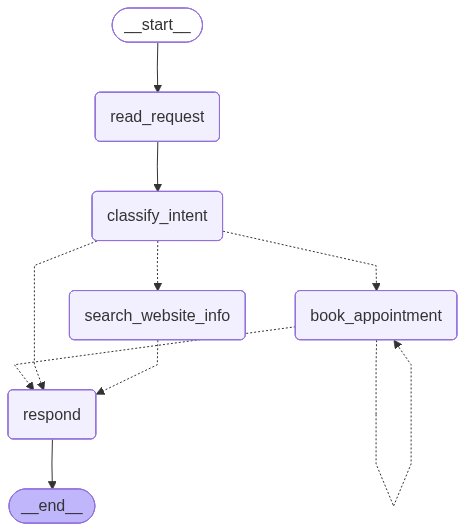

In [4]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [108]:

initial_state = MentalHealthAgentState()
#initial_state["user_message"] = "I'm feeling so cold and lost. Dont know if I can go on like this. Thinking about ending it all."
#initial_state["user_message"]= "Can you tell me about the therapy services you offer?"
initial_state["user_message"]= "Can i get an appointment to see a therapist"

initial_state["messages"] = []


# Run with a thread_id for persistence
config = {"configurable": {"thread_id": "patient_689o0"}}


In [96]:
initial_state

{'user_message': 'Can i get an appointment to see a therapist', 'messages': []}

In [109]:
from langgraph.types import Command
from typing import Callable, Optional

def run_graph_until_complete(app, initial_state, config,
                             resolve_interrupt: Optional[Callable[[dict], dict]] = None):
    """
    End-to-end runner that:
    - Streams the first execution (to get intermediate output)
    - Detects interrupt payloads
    - Resumes using Command(resume=...)
    - Handles multiple sequential interrupts
    """

    # Fallback resolver (dummy answers)
    if resolve_interrupt is None:
        def resolve_interrupt(payload):
            t = payload.get("type")
            return {
                "user_Fname": {"user_Fname": "John"},
                "user_Lname": {"user_Lname": "Doe"},
                "user_email": {"user_email": "john@example.com"},
                "user_phonenumber": {"user_phonenumber": "08012345678"},
            }.get(t, {"value": "default"})
        resolve_interrupt = resolve_interrupt

    # --- 1) INITIAL STREAM ---
    print("=== STREAMING INITIAL EXECUTION ===")
    events = list(app.stream(initial_state, config))
    for ev in events:
        print("[STREAM EVENT]", ev)

    # Last stream event determines whether we continue or finish
    result = events[-1] if events else {}

    # --- 2) LOOP: HANDLE MULTIPLE INTERRUPTS ---
    while "__interrupt__" in result:

        # Extract the interrupt payload (LangGraph returns a list)
        interrupt = result["__interrupt__"][0]
        payload = interrupt.value
        print("\n>>> INTERRUPT PAYLOAD:", payload)

        # Resolve user/synthetic input for the interrupt
        resume_value = resolve_interrupt(payload)
        print(">>> RESUME VALUE:", resume_value)

        # Resume using documented method (no stream here!)
        result = app.invoke(Command(resume=resume_value), config=config)
        print("\n[INVOKE RESULT AFTER RESUME]", result)

        # Loop continues — if a new interrupt appears in this result,
        # this while-loop will handle it again.

    # --- 3) NO MORE INTERRUPTS → DONE ---
    print("=== GRAPH COMPLETE ===")
    return result 
initial_state = run_graph_until_complete(app, initial_state, config)

=== STREAMING INITIAL EXECUTION ===
Booking appointment...
{'user_message': 'Can i get an appointment to see a therapist', 'classification': {'urgency': 'stable', 'summary_request': 'The user is requesting to book an appointment to see a therapist.', 'intent': 'booking'}, 'messages': [HumanMessage(content='Processing request: Can i get an appointment to see a therapist', additional_kwargs={}, response_metadata={}, id='d1fcf20d-1aa3-4a21-9de6-db40f97bd9a4')]}
[STREAM EVENT] {'read_request': {'messages': [HumanMessage(content='Processing request: Can i get an appointment to see a therapist', additional_kwargs={}, response_metadata={}, id='d1fcf20d-1aa3-4a21-9de6-db40f97bd9a4')]}}
[STREAM EVENT] {'classify_intent': {'classification': {'urgency': 'stable', 'summary_request': 'The user is requesting to book an appointment to see a therapist.', 'intent': 'booking'}}}
[STREAM EVENT] {'__interrupt__': (Interrupt(value={'type': 'user_Fname', 'message': 'User First name Required', 'request': "Be

In [67]:
initial_state 

{'user_message': 'Can i get an appointment to see a therapist',
 'user_Fname': 'John',
 'user_Lname': 'Doe',
 'user_email': 'john@example.com',
 'user_phonenumber': '08012345678',
 'booked': True,
 'appointment_date': '12/14/2025',
 'classification': {'urgency': 'stable',
  'intent': 'booking',
  'summary_request': 'Can i get an appointment to see a therapist'},
 'response': 'I can help you book that appointment with a therapist. What day and time would work best for you?',
 'messages': [HumanMessage(content='Processing request: Can i get an appointment to see a therapist', additional_kwargs={}, response_metadata={}, id='9714c1e5-d8da-454d-95d0-01f7c5d95987'),
  AIMessage(content='I can help you book that appointment with a therapist. What day and time would work best for you?', additional_kwargs={}, response_metadata={}, id='456542ac-9691-4e1a-b6e1-553ede339689')]}

In [110]:

#initial_state["user_message"] = "I'm feeling so cold and lost. Dont know if I can go on like this. Thinking about ending it all."
#initial_state["user_message"].update("Can you tell me about the therapy services you offer?")
new_input = {"user_message": "what can i do to help with stressful days"}
app.invoke(new_input, config)
#initial_state = app.invoke(initial_state, config)

{'response': "It sounds like you're looking for ways to manage stressful days. We're here to support you. Sometimes, talking through what you're experiencing can be really helpful. Our organization offers various services that might be beneficial. Would you like to know more about how we can help?"}


{'user_message': 'what can i do to help with stressful days',
 'user_Fname': 'John',
 'user_Lname': 'Doe',
 'user_email': 'john@example.com',
 'user_phonenumber': '08012345678',
 'booked': True,
 'appointment_date': '12/5/2025',
 'classification': {'urgency': 'stable',
  'intent': 'conversational',
  'summary_request': 'User is asking for coping strategies for stressful days.'},
 'response': "It sounds like you're looking for ways to manage stressful days. We're here to support you. Sometimes, talking through what you're experiencing can be really helpful. Our organization offers various services that might be beneficial. Would you like to know more about how we can help?",
 'messages': [HumanMessage(content='Processing request: Can i get an appointment to see a therapist', additional_kwargs={}, response_metadata={}, id='d1fcf20d-1aa3-4a21-9de6-db40f97bd9a4'),
  AIMessage(content='Your appointment has been successfully booked for December 5, 2025. We are here to support you.', addition

In [78]:
initial_state

{'user_message': 'Can i get an appointment to see a therapist',
 'user_Fname': 'John',
 'user_Lname': 'Doe',
 'user_email': 'john@example.com',
 'user_phonenumber': '08012345678',
 'booked': True,
 'appointment_date': '12/8/2025',
 'classification': {'urgency': 'stable',
  'intent': 'booking',
  'summary_request': 'Can i get an appointment to see a therapist'},
 'response': 'Your appointment has been booked for 12/8/2025. We look forward to seeing you then.',
 'messages': [HumanMessage(content='Processing request: Can i get an appointment to see a therapist', additional_kwargs={}, response_metadata={}, id='519792cd-b454-426e-935d-46413ac9bcf7'),
  AIMessage(content='Your appointment has been booked for 12/15/2025. We look forward to seeing you then.', additional_kwargs={}, response_metadata={}, id='3e1faa17-b33e-45fe-84ff-faeed25e2010'),
  HumanMessage(content='Processing request: Can i get an appointment to see a therapist', additional_kwargs={}, response_metadata={}, id='d3e4912d-5de